# Conversion Rate

* [Goal](#Goal)
* [Data Explaination](#Data)
* [Load Dataset](#Load-Dataset)
* [Exploratory Data](#Exploratory-Data)
    * [Visualizing categorical features](#Visualizing-categorical-features)
    * [Visualizing numerical features](#Visualizing-numerical-features)
* [Feature Engineering](#Feature-Engineering)
    * [Feature Importance](#Feature-Importance)
* [Build Classification Model](#Build-Classification-Model)
* [Evaluating the Model](#Evaluating-the-Model)
* [Conclusions](#Conclusions)

## Goal
The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

The raw data has users who hit our site: whether they converted (bought something when they visited our website) or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). Your project is to:
* Predict conversion rate
* Come up with recommendations for the product team and the marketing team to improve conversion rate

## Data

**The table is "conversion_data". It has information about signed-in users during one session. Each row is a user session.**

**Columns:**
* country : user country based on the IP address
* age : user age. Self-reported at sign-in step
* new_user : whether the user created the account during this session or had already an account and simply came back to the site. 
    * 1 means new user - the user created the account during this session.
* source : marketing channel source
    * Ads: came to the site by clicking on an advertisement
    * Seo: came to the site by clicking on search results
    * Direct: came to the site by directly typing the URL on the browser
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session. 
    * e.g., 1 - the user visited just 1 page during that session. 
* converted: this is our label. 1 means they converted (purchased items) within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions/total sessions.

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.6f' % x)

#  Load Dataset

In [2]:
df = pd.read_csv("01_conversion_data.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
# understand the components of each column

for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s}{1:5d}\t{2}'.format(column, len(uniques), uniques[:10]))

country                 4	['China', 'Germany', 'UK', 'US']
age                    60	[17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
new_user                2	[0, 1]
source                  3	['Ads', 'Direct', 'Seo']
total_pages_visited    29	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
converted               2	[0, 1]


###  Remove Outliers

* check if there is any outliers in **age** column

In [6]:
df['age'].describe()

count   316200.000000
mean        30.569858
std          8.271802
min         17.000000
25%         24.000000
50%         30.000000
75%         36.000000
max        123.000000
Name: age, dtype: float64

In [7]:
# check age greater than 90

df[df['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


* there are two rows with age greater than 100. We can remove these two rows. 

In [8]:
# get a new dataframe without age greater than 100

df = df[df['age'] < 100].reset_index(drop=True)

# Exploratory Data 

## Visualizing categorical features

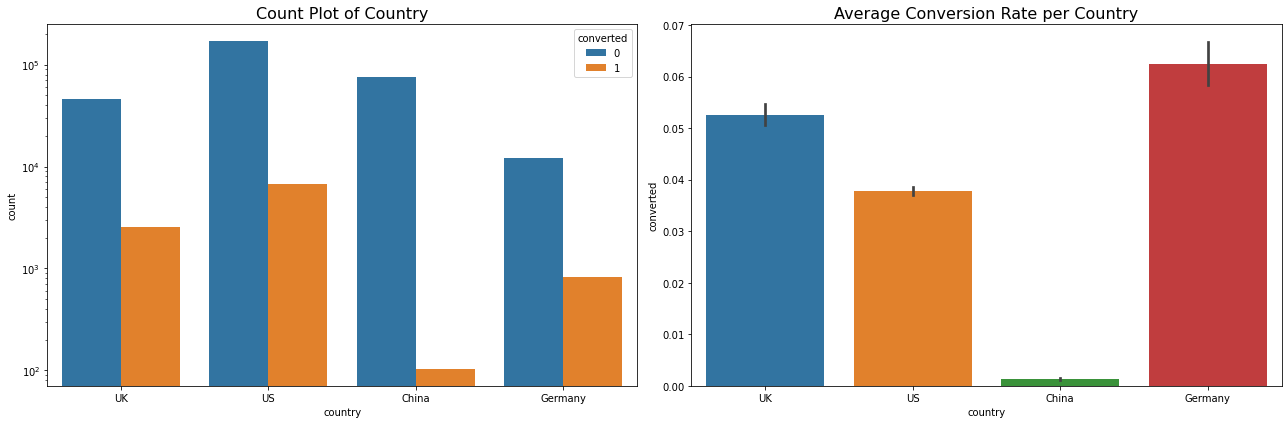

In [9]:
# Visualize the convertion rate by country.

grouped = df[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=df, ax=ax[1])
ax[1].set_title('Average Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

* Gemany has highest convention rate among 4 countries. 
* China's convention rate is significantly lower than others. 

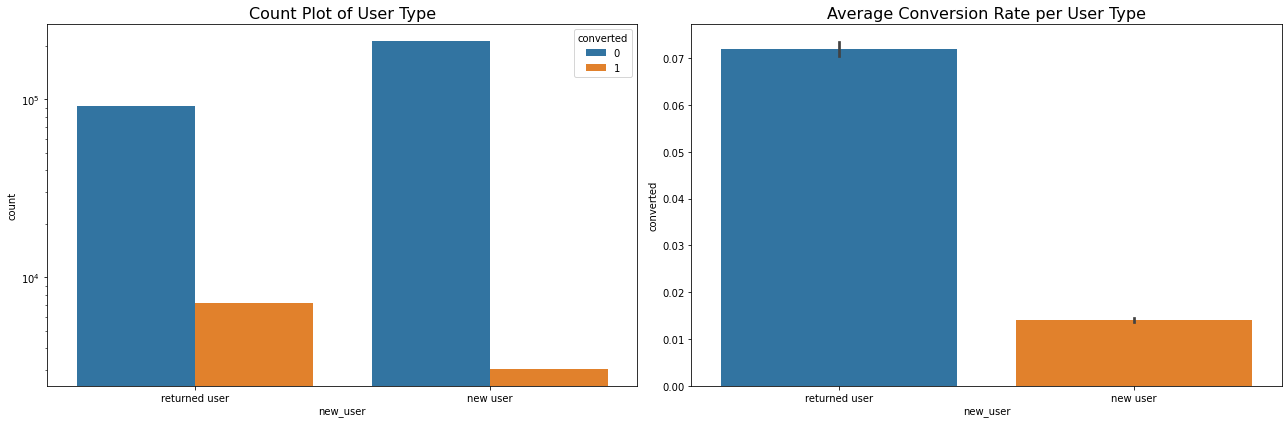

In [10]:
# Visualize the convention rate by user type.

grouped = df[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of User Type', fontsize=16)
ax[0].set_yscale('log')
labels = ['returned user', 'new user']
ax[0].set_xticklabels(labels)
sns.barplot(x='new_user', y='converted', data=df, ax=ax[1])
ax[1].set_title('Average Conversion Rate per User Type', fontsize=16)
ax[1].set_xticklabels(labels)
plt.tight_layout()
plt.show()

* The returned users have better convertion rate than new users.

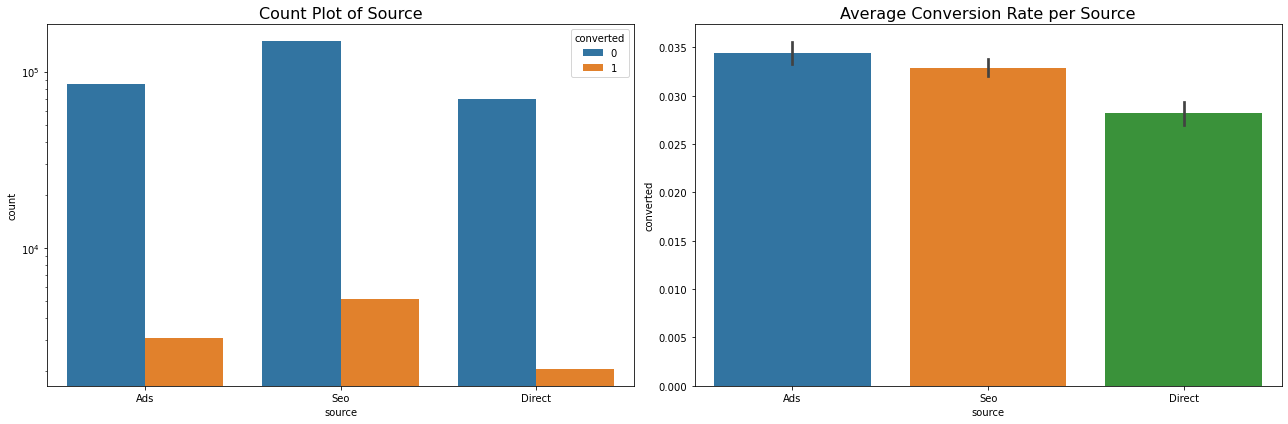

In [11]:
# Visualize convertion rate by Source.
grouped = df[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Source', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=df, ax=ax[1])
ax[1].set_title('Average Conversion Rate per Source',fontsize=16)
plt.tight_layout()
plt.show()

* There is no obviously different for convertion rate between different source. 

## Visualizing numerical features

In [12]:
hist_kws={'histtype':'bar', 'edgecolor':'black', 'alpha':0.2}

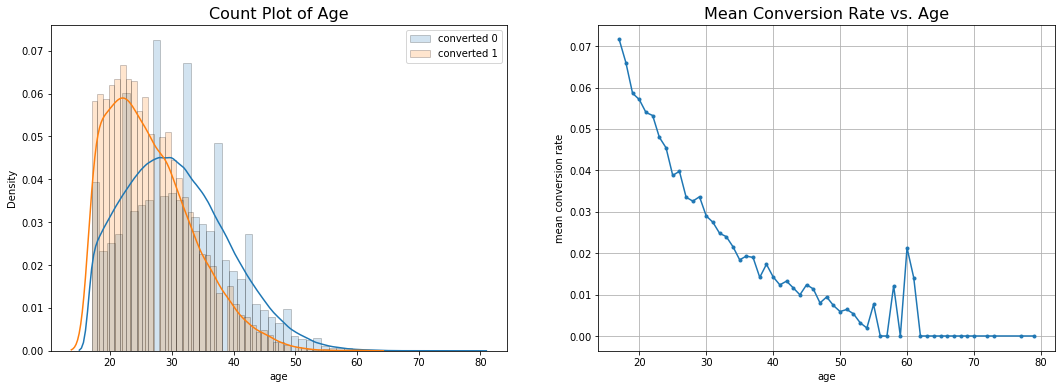

In [13]:
# Visualize the convention rate by age.
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.distplot(df[df['converted'] == 0]['age'], label = 'converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['age'], label = 'converted 1', ax=ax[0], hist_kws=hist_kws)
# sns.displot(df, x='age', hue='converted', ax=ax[0], alpha = 0.2, edgecolor='black')
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('mean conversion rate')
ax[1].grid(True)
plt.show()

* the conversion rate declines with age increasing. 

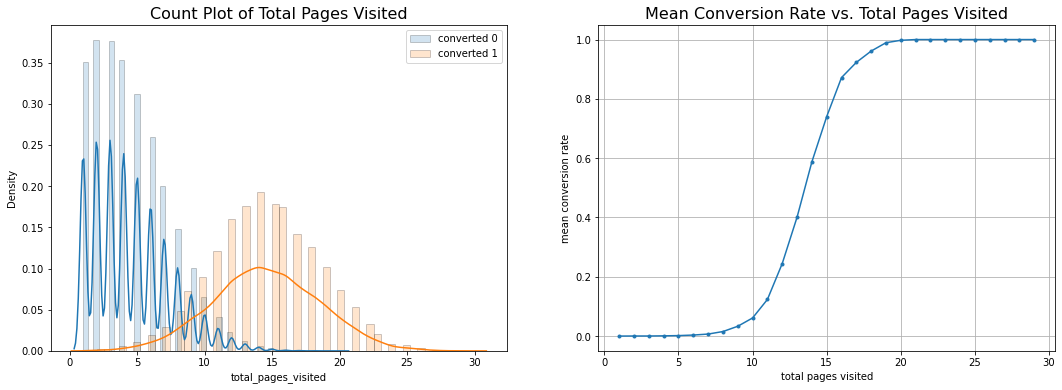

In [14]:
# visualize the convention rate by # of pages visited.

grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.distplot(df[df['converted'] == 0]['total_pages_visited'], label = 'converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['total_pages_visited'], label = 'converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Total Pages Visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total Pages Visited', fontsize=16)
ax[1].set_xlabel('total pages visited')
ax[1].set_ylabel('mean conversion rate')
ax[1].grid(True)
plt.show()

* conversion rate increases as user visited more pages

# Feature Engineering
* Build a model to predict conversion rate
* find feature importance and come up with ideas to improve revenue

## convert categorical data into numerical

In [15]:
print(df.shape)
df.head(2)

(316198, 6)


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_new = df.copy()

df_new['country'] = le.fit_transform(df['country'])
df_new['source'] = le.fit_transform(df['source'])

**Transform Results for country and source**
* China: 0; Germany: 1; UK: 2; US: 3
* Ads: 0; Direct: 1; Seo: 2

In [17]:
df_new.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


## Feature Importance

In [18]:
# split data into X and y

X = df_new.drop('converted', axis=1).values
y = df_new['converted']
print(X.shape)
print(y.shape)

(316198, 5)
(316198,)


In [19]:
# run tree-based estimator to check feature importance

from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=10)
clf_dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [20]:
# run feature importance

fi_col = []
fi = []

for i, column in enumerate(df_new.drop('converted', axis=1)):
    print("The feature importance for {} is {}".format(column, clf_dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(clf_dt.feature_importances_[i])

The feature importance for country is 0.040747729703241
The feature importance for age is 0.02736449170982146
The feature importance for new_user is 0.04673523388490698
The feature importance for source is 0.004058127354892772
The feature importance for total_pages_visited is 0.8810944173471379


In [21]:
# create a dataframe

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns=['feature', 'feature_importance'])
fi_df = fi_df.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)
fi_df

,feature,feature_importance
0,total_pages_visited,0.881094
1,new_user,0.046735
2,country,0.040748
3,age,0.027364
4,source,0.004058


* the total_pages_visited is the most important feature in predicting if the customer is converted or not

# Build Classification Model

* split data into train data set and test data set
* fit logistic regression model

* Because the two classes in convertion are imbalanced, I use StratifiedShuffleSplit to split the data into training and test sets and maintains the proportion of classes in both the training and test sets. 

In [22]:
# get the split indexes by using stratified sampliing method
# split data into train dataset and test data set

from sklearn.model_selection import StratifiedShuffleSplit

# using StratifiedShuffleSplit to make sure the proporiton of distribution of class labels 
# is almost even between train and test dataset
strat_shuf_split = StratifiedShuffleSplit(n_splits=2,  # number of re-shuffling & splitting iterations, 2 gives 2 split records
                                         test_size=0.3,
                                         random_state=42)

# retrive the next item from the iterator
cols = ['new_user', 'country', 'age', 'total_pages_visited'] # 'source',   
train_idx, test_idx = next(strat_shuf_split.split(df_new[cols], df_new['converted']))  # next() returns the next item in an iterator

X_train = df_new.loc[train_idx, cols]
y_train = df_new.loc[train_idx, 'converted']

X_test = df_new.loc[test_idx, cols]
y_test = df_new.loc[test_idx, 'converted']

print(len(y_train))
print(len(y_test))

221338
94860


In [23]:
# for a, b in strat_shuf_split.split(df_new[cols], df_new['converted']):
#     print(a)
#     print(len(a))
#     print(b)
#     print(len(b))

In [24]:
# Fit logistic regression model

from sklearn.linear_model import LogisticRegression

# standard logistic regression model
log_reg = LogisticRegression(random_state = 42, solver= 'liblinear')
log_reg.fit(X_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LogisticRegression(random_state=42, solver='liblinear')

In [25]:
# predict the class and the probability for each sample

y_pred = list()
y_prob = list()

y_pred.append(pd.Series(log_reg.predict(X_train), name='lr_predict_train'))
y_prob.append(pd.Series(log_reg.predict_proba(X_train).max(axis=1), name='lr_predict_proba_train'))

y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred_n_prob = pd.concat([y_pred,y_prob], axis=1)
y_pred_n_prob.head()

,lr_predict_train,lr_predict_proba_train
0,0,0.999539
1,0,0.999090
2,0,0.999705
3,1,0.770728
4,0,0.997415


In [26]:
# coefficient of the features 
print(log_reg.coef_)
print(cols)

[[-1.7397389   0.48996367 -0.07768266  0.75831708]]
['new_user', 'country', 'age', 'total_pages_visited']


* total_pages_visited has positive relationship (coef: 0.76) with conversion rate (the predicted variable).

# Evaluating the Model

In [27]:
# accuracy on Training data set
print("The training data accuracy is: ", log_reg.score(X_train, y_train))

# accuracy on test data set
print("The test data accuracy is: ", log_reg.score(X_test, y_test))

The training data accuracy is:  0.985470185869575
The test data accuracy is:  0.9856419987349778


* prediction accuracy is 99% for both training data set and test data set.

In [28]:
# Classification Report
print(classification_report(y_train, y_pred))

# including source feature doesn't change prediction result

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    214199
           1       0.85      0.67      0.75      7139

    accuracy                           0.99    221338
   macro avg       0.92      0.83      0.87    221338
weighted avg       0.98      0.99      0.98    221338



**classification report** 
 1. precision (0): TP(0)/(TP(0) + FP(0)) = 213343/(213343+2360) = 0.99. 
    - When model predict result is unconverted, 99% of chance is truly unconverted. 
    
    
 2. precision (1): TP(1)/(TP(1) + FP(1)) = 4779/(4779+856) = 0.85. 
    - When model predict result is converted, 85% of chance is truly converted. 
    
    
 3. recall (0): TP(0) / (TP(0) + FN(0)) = 213343/(213343+ 856) = 1. 
    - Out of all unconverted users, all most 100% is predicted as unconverted. 
    
    
 4. recall (1): TP(1) / (TP(1) + FN(1)) = 4779/(4770+ 2360) = 0.67. 
    - Out of all converted users, 67% is predicted as converted. 
    
    
 5. accuracy = (TP + TN) / (TP + FN + FP + TN) = (4770 + 213343)/(4779 + 2360 + 856 + 213343) = 0.99. 
    - Out of total predictions, 99% is predicted correct. 

In [29]:
# confusion matrix function
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes=None, title= 'Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(8, 8))
    """Plot a confusion matrix"""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True,
                   annot_kws={'size': 30}, ax=ax, fmt=".1f")
    else:
        sns.heatmap(cm, vmin=0., vmax=1., ax=ax, fmt=".1f")
    
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

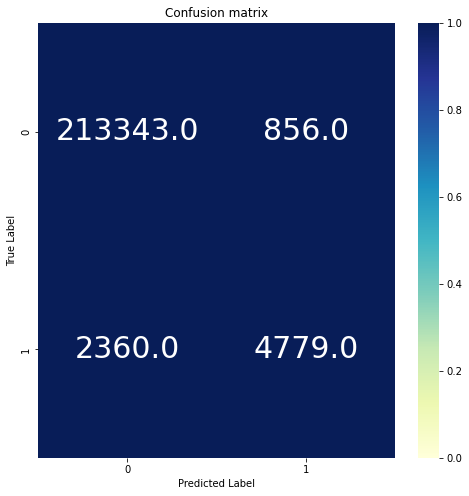

In [30]:
# visualizing confusion matrix

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm, classes = log_reg.classes_, title='Confusion matrix')

# Conclusions

* total_pages_visited is the key factors to predict if customer will buy something on the website or not. The more pages a customer visited, the more time a customer spent on site and the more likely a customer will buy something on the website. 

**Suggestions** \
The company need to increase the number of pages visited by each customer 
* make sure site with thoughtful and easy to use navigation 
* maintian a fast site 
* Develop mobile site/app because it's easier for customers to access through mobile site or app. 